In [1]:
# Deeper dive into featurization methods for GA vibration data
# We ultimately want something predective . . . where we can see start to move into "scary" land
# We'll compare blunt frequency analysis methods (band pass energy aggregation) and PCA

In [2]:
import pandas as pd
from numpy.fft import fft, fftshift
from scipy.signal import welch
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from plotnine import *
from sklearn.cluster import KMeans, AgglomerativeClustering

%matplotlib notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = [6, 2]
from random import randint

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


%matplotlib notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = [6, 2]
from random import randint

from matplotlib import animation

In [3]:
def read_ga_file(file_path):
    df = pd.read_csv(file_path, header=None)
    ncol = df.shape[1]
    start_cols = ["id", 'path', "something", "axis", "unix_time", "some_number", "number_samples"] 
    end_cols = range(0, ncol-len(start_cols))
    cols = start_cols + list(end_cols)
    df.columns = cols
    df['datetime'] = pd.to_datetime(df['unix_time'], unit='ms')
    return df

In [4]:
def compute_spectra_from_df(df):
    nums = np.arange(0, 1650)
    S = df[nums].values
    X = np.zeros((S.shape[0], 413))
    for ii in range(S.shape[0]):
        Ft, Xt = welch(S[ii, :], nfft=825)
        X[ii, :] = Xt
    return Ft, X


In [5]:
def compute_spectra_from_df_parseval(df):
    
    fs = 4096
    num_samples=df['number_samples'].iloc[0]
    nums = list(range(num_samples))
    S = df[nums].values
    
    Ft = np.linspace(-fs/2, fs/2, num_samples)
    X = np.zeros((S.shape[0], num_samples))
    for ii in range(S.shape[0]):
        Xt = fftshift(fft(S[ii, :]))
        Xt = Xt * np.conj(Xt)
        Xt = np.real(Xt) / len(Xt)
        X[ii, :] = Xt
        #print(len(X))
        #print(np.sum(Xt))
        #print(np.sum(S[ii, :]**2))
        #print()
    return Ft, X, num_samples

In [ ]:
def zeb_fft(df):
    pass

In [6]:
#data_files_path = r"C:\MyData\GP\Waveform"
#results_path = r"C:\MyData\GP\FFT"
#data_files_path = r"D:\Projects\GP QRCM\Waveform Data"
data_files_path = r"P:\Open Projects\Georgia Pacific\Open Projects\3022\Vibration Data\test"
results_path = r"C:\Users\Zebulon.Bell\OneDrive - Pinnacle\Desktop\fft results"

os.chdir(data_files_path)
current_path = os.getcwd()
print(f"Current Path is set to {current_path}")


for root, dirs, files in os.walk(data_files_path):
    #print(root)
    for file in files:
        file_path = os.path.join(root, file)
        #print(f"Root is {root}")
        full_results_path = root.replace(data_files_path, results_path)
        #print(f"FFT Results path is {full_results_path}")
        os.makedirs(full_results_path, exist_ok = True)
        
        # Get file extension
        #print(os.path.splitext(file_path)[1])
        
        
        print(f"\t{file_path}")
        
        output_file_path = os.path.join(full_results_path, file)
            
        df = read_ga_file(file_path)
        print(df.shape)
        
        Ft, X, num_samples = compute_spectra_from_df_parseval(df)
        print(num_samples)
        freq_dft = pd.DataFrame(X)
        freq_dft["axis"] = df["axis"].values
        freq_dft["path"] = df["path"].values
        freq_dft["datetime"] = df["datetime"].values

        # Need this to translate integer dataframe columns to frequencies while not messing up the non-integer ones
        in_cols = freq_dft.columns.values
        out_cols = []
        for col in in_cols:
            if col in ['axis', 'datetime', 'date', 'path']:
                out_cols.append(col)
            else:
                #out_cols.append((float(col)/num_samples) * (4096/2))
                out_cols.append(Ft[col])

        conv_dict = dict(zip(in_cols, out_cols))

        freq_dft = freq_dft.rename(columns=conv_dict)
        freq_dft["date"] = freq_dft["datetime"].apply(lambda x: x.date())
        freq_dft.to_csv(output_file_path, index=None)
        
        #takes the full datatable and shrinks it down to what we need.
        
            
            

Current Path is set to P:\Open Projects\Georgia Pacific\Open Projects\3022\Vibration Data\test
	P:\Open Projects\Georgia Pacific\Open Projects\3022\Vibration Data\test\0122.csv
(4264, 4104)
4096


<IPython.core.display.Javascript object>


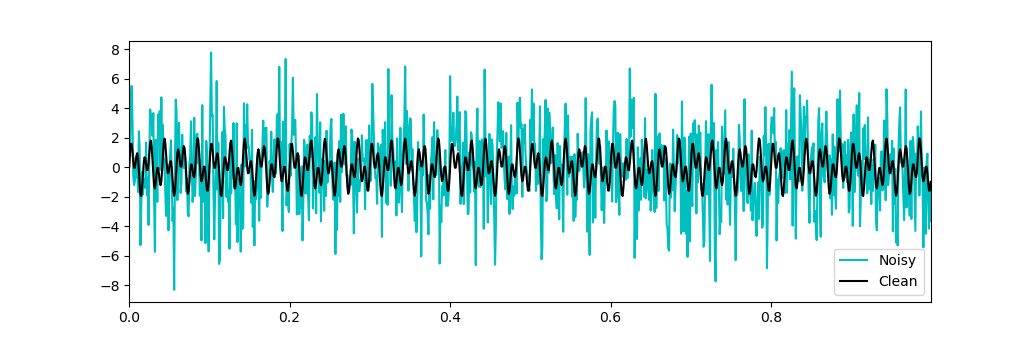

In [9]:
dt = 0.001
t= np.arange(0,1,dt)
f = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t)
f_clean = f
f = f + 2.5*np.random.randn(len(t))

plt.plot(t,f,color = 'c',  label = 'Noisy')
plt.plot(t,f_clean,color = 'k',  label = 'Clean')
plt.xlim(t[0],t[-1])
plt.legend()

<IPython.core.display.Javascript object>


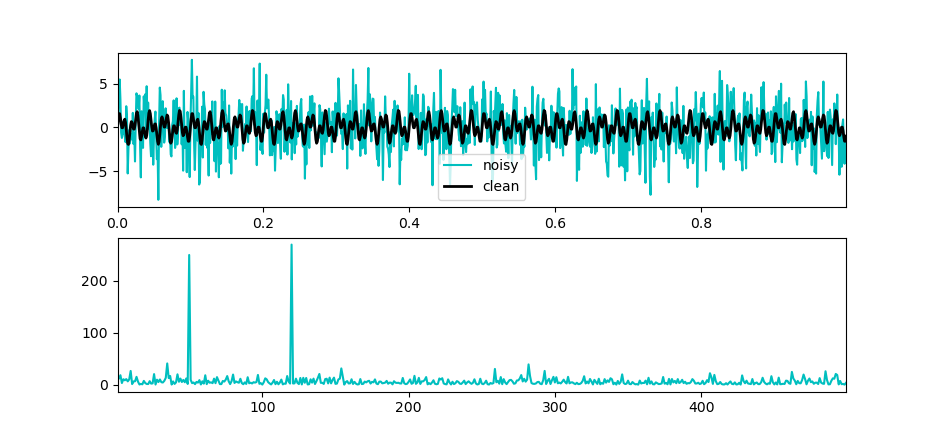

C:\Users\Zebulon.Bell\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [23]:
n = len(t)
fhat = np.fft.fft(f,n)
PSD = fhat * np.conj(fhat) / n
freq = (1/(dt*n)) * np.arange(n)
L = np.arange(1,np.floor(n/2),dtype='int')

fig,axs = plt.subplots(2,1)

plt.sca(axs[0])
plt.plot(t,f,color='c', linewidth=1.5, label='noisy')
plt.plot(t,f_clean,color='k', linewidth=2,  label='clean')

plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(freq[L],PSD[L],color='c',label='noisy')
plt.xlim(freq[L[0]],freq[L[-1]])

plt.show()

In [27]:
len(t)

1000